In [38]:
# Importation des librairies nécessaires
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from cinelytics_sdk import MovieClient, MovieConfig
import time
import json
from collections import Counter, defaultdict
from pathlib import Path

In [39]:
# Dossiers
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

In [40]:
# Initialisation du client avec l'URL de l'API
config = MovieConfig(movie_base_url="https://cinema-insights.onrender.com")
client = MovieClient(config=config)

# # Vérification que l'API est opérationnelle
client.health_check()

MOVIE_API_BASE_URL in MovieConfig init: https://cinema-insights.onrender.com


{'message': "Bienvenue sur l'API CINEMA_INSIGHTS. Statut : OK"}

In [41]:
# Récupération des stats de l'API
analytics = client.get_analytics()
analytics

AnalyticsResponse(movie_count=9742, rating_count=100836, tag_count=3683, link_count=9742)

## Analyse du Comportement des Utilisateurs

In [42]:
import os
# Chemins des fichiers
#output_dir = "output"
ratings_path = os.path.join(output_dir, "ratings.parquet")

# Vérifier si le dossier output existe
os.makedirs(output_dir, exist_ok=True)

# Obtenir le nombre total d'évaluations
current_rating_count = analytics.rating_count

# Recharger ou régénérer les données
if os.path.exists(ratings_path):
    ratings_df = pd.read_parquet(ratings_path)
    if ratings_df.shape[0] != current_rating_count:
        print("Les données ont changé, rechargement depuis l’API…")
        ratings_df = []
        limit, skip = 1000, 0
        while True:
            batch = client.list_ratings(skip=skip, limit=limit, output_format="pandas")
            if batch.empty:
                break
            ratings_df.append(batch)
            skip += limit
            time.sleep(0.5)
        ratings_df = pd.concat(ratings_df, ignore_index=True)
        ratings_df.to_parquet(ratings_path, index=False)
    else:
        print("Données en cache réutilisées.")
else:
    print("Aucune donnée en cache trouvée, téléchargement initial…")
    ratings_df = []
    limit, skip = 1000, 0
    while True:
        batch = client.list_ratings(skip=skip, limit=limit, output_format="pandas")
        if batch.empty:
            break
        ratings_df.append(batch)
        skip += limit
        time.sleep(0.5)
    ratings_df = pd.concat(ratings_df, ignore_index=True)
    ratings_df.to_parquet(ratings_path, index=False)

Données en cache réutilisées.


In [43]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [44]:
# Graphe 1 : Nombre d’évaluations par utilisateur
ratings_per_user = ratings_df['userId'].value_counts().reset_index()
ratings_per_user.columns = ['userId', 'rating_count']
top_users = ratings_per_user.head(10)

# Bar plot horizontal
fig1 = px.bar(
    top_users,
    x="rating_count",
    y=top_users["userId"].astype(str),  # conversion en string pour éviter une échelle numérique
    orientation="h",
    title="Top 10 des utilisateurs par nombre d’évaluations",
    labels={"userId": "Utilisateur", "rating_count": "Nombre d’évaluations"},
    color="rating_count",
    color_continuous_scale="viridis"
)

# Tri pour avoir le plus gros en haut
fig1.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=500
)

fig1.show()

In [45]:
# Graphe 2 : Distribution des notes données
fig2 = px.histogram(
    ratings_df,
    x="rating",
    nbins=10,
    title="Distribution des notes données",
    labels={"rating": "Note"},
)
fig2.update_layout(bargap=0.1)
fig2.show()

In [46]:
# Graphe 3 : Utilisateurs très positifs vs très critiques
avg_rating_per_user = ratings_df.groupby("userId")["rating"].mean().reset_index()
fig3 = px.histogram(
    avg_rating_per_user,
    x="rating",
    nbins=50,
    title="Répartition des moyennes de notes par utilisateur",
    labels={"rating": "Note moyenne"},
)
fig3.update_layout(bargap=0.1)
fig3.show()

## Top 10 des genres par nombre de films

In [47]:
# Système sans mise en cache

# Initialisation du compteur de genres
"""
genre_counter = Counter()

# Paramètres pour le batching
limit = 1000
skip = 0

while True:
    batch = client.list_movies(skip=skip, limit=limit, output_format="dict")
    if not batch:
        break
    
    # On extrait les genres du lot et les compte
    for movie in batch:
        genres = movie.get("genres", "")
        genre_list = genres.split("|") if genres else []
        genre_counter.update(genre_list)
    
    skip += limit
    time.sleep(0.5)  # Pour respecter l’API

# Conversion du Counter en DataFrame
genre_df = pd.DataFrame(genre_counter.items(), columns=["genre", "count"])
genre_df = genre_df.sort_values("count", ascending=False).head(10)
genre_df
# Bar chart horizontal
fig = px.bar(
    genre_df,
    x="count",
    y="genre",
    title="Top 10 genres par nombre de films",
    labels={"genre": "Genre", "count": "Nombre de films"},
    color="count",
    color_continuous_scale="viridis",
    orientation='h'  # ← clé pour l'affichage horizontal
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},  # trie du haut vers le bas
    height=500
)

fig.show()
"""

'\ngenre_counter = Counter()\n\n# Paramètres pour le batching\nlimit = 1000\nskip = 0\n\nwhile True:\n    batch = client.list_movies(skip=skip, limit=limit, output_format="dict")\n    if not batch:\n        break\n\n    # On extrait les genres du lot et les compte\n    for movie in batch:\n        genres = movie.get("genres", "")\n        genre_list = genres.split("|") if genres else []\n        genre_counter.update(genre_list)\n\n    skip += limit\n    time.sleep(0.5)  # Pour respecter l’API\n\n# Conversion du Counter en DataFrame\ngenre_df = pd.DataFrame(genre_counter.items(), columns=["genre", "count"])\ngenre_df = genre_df.sort_values("count", ascending=False).head(10)\ngenre_df\n# Bar chart horizontal\nfig = px.bar(\n    genre_df,\n    x="count",\n    y="genre",\n    title="Top 10 genres par nombre de films",\n    labels={"genre": "Genre", "count": "Nombre de films"},\n    color="count",\n    color_continuous_scale="viridis",\n    orientation=\'h\'  # ← clé pour l\'affichage horiz

In [48]:
####### Avec Système de mise en cache #########


api_movie_count = analytics.movie_count
print(api_movie_count)

genre_data_file = output_dir / "genre_df.parquet"
meta_file = output_dir / "meta.json"

# Lecture du fichier méta s'il existe
if meta_file.exists():
    with open(meta_file, "r") as f:
        meta = json.load(f)
    cached_movie_count = meta.get("movie_count", 0)
else:
    meta = {}
    cached_movie_count = 0

# Décision : utiliser le cache ou recalculer
if genre_data_file.exists() and cached_movie_count == api_movie_count:
    print("Chargement des données depuis le cache...")
    genre_df = pd.read_parquet(genre_data_file)
else:
    print("Mise à jour des données depuis l'API...")
    # Initialisation du compteur de genres
    genre_counter = Counter()

    # Paramètres pour le batching
    limit = 1000
    skip = 0

    while True:
        batch = client.list_movies(skip=skip, limit=limit, output_format="dict")
        if not batch:
            break

        # On extrait les genres du lot et les compte
        for movie in batch:
            genres = movie.get("genres", "")
            genre_list = genres.split("|") if genres else []
            genre_counter.update(genre_list)

        skip += limit
        time.sleep(0.5)  # Pour respecter l’API

    # Conversion du Counter en DataFrame
    genre_df = pd.DataFrame(genre_counter.items(), columns=["genre", "count"])
    genre_df = genre_df.sort_values("count", ascending=False).head(10)

    # Sauvegarde
    genre_df.to_parquet(genre_data_file, index=False)
    with open(meta_file, "w") as f:
        json.dump({"movie_count": api_movie_count}, f)

# Affichage Plotly
fig = px.bar(
    genre_df,
    x="count",
    y="genre",
    title="Top 10 genres par nombre de films",
    labels={"genre": "Genre", "count": "Nombre de films"},
    color="count",
    color_continuous_scale="viridis",
    orientation='h'
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    height=500
)

fig.show()

9742
Chargement des données depuis le cache...


## Nombre total de films par année (basée sur le titre)

In [49]:
import re

# === Dossiers ===
#output_dir = Path("output")
#output_dir.mkdir(exist_ok=True)

yearly_data_file = output_dir / "movies_by_year.parquet"
meta_file = output_dir / "meta_movies_by_year.json"

# === Récupération du nombre total de films via analytics ===
#analytics = client.get_analytics()
api_movie_count = analytics.movie_count

# === Lecture du cache s’il existe ===
if meta_file.exists():
    with open(meta_file, "r") as f:
        meta = json.load(f)
    cached_movie_count = meta.get("movie_count", 0)
else:
    cached_movie_count = 0

# === Utilisation du cache ou recalcul ===
if yearly_data_file.exists() and cached_movie_count == api_movie_count:
    print("Chargement des données depuis le cache...")
    df_yearly = pd.read_parquet(yearly_data_file)

else:
    print("Extraction des années depuis l’API...")

    # === Initialisation ===
    year_counter = Counter()
    skip = 0
    limit = 500
    year_pattern = re.compile(r"\((\d{4})\)$")

    while True:
        batch = client.list_movies(skip=skip, limit=limit, output_format="dict")
        if not batch:
            break

        for movie in batch:
            title = movie.get("title", "")
            match = year_pattern.search(title)
            if match:
                year = int(match.group(1))
                year_counter[year] += 1

        skip += limit
        time.sleep(0.5)

    # === Construction du DataFrame ===
    df_yearly = pd.DataFrame(sorted(year_counter.items()), columns=["year", "movie_count"])

    # === Sauvegarde du cache ===
    df_yearly.to_parquet(yearly_data_file, index=False)
    with open(meta_file, "w") as f:
        json.dump({"movie_count": api_movie_count}, f)

# === Affichage avec Plotly ===
fig = px.bar(
    df_yearly,
    x="year",
    y="movie_count",
    title="Nombre total de films par année (basé sur le titre)",
    labels={"year": "Année", "movie_count": "Nombre de films"},
)

fig.update_layout(
    xaxis_title="Année",
    yaxis_title="Nombre de films",
    height=500
)

fig.show()

Chargement des données depuis le cache...


In [50]:
df_yearly

,year,movie_count
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1916,4
...,...,...
101,2014,277
102,2015,274
103,2016,218
104,2017,147


## # 📊 Fonction : Générer ou charger les statistiques de notation par genre

In [51]:
print("📋 Colonnes ratings_df :", ratings_df.columns.tolist())
print("📋 Colonnes genre_df   :", genre_df.columns.tolist())


📋 Colonnes ratings_df : ['userId', 'movieId', 'rating', 'timestamp']
📋 Colonnes genre_df   : ['genre', 'count']


In [52]:
# from IPython.display import display, Markdown
# import os, json
# import pandas as pd

# display(Markdown("### 🔍 Analyse de la moyenne des notes par genre et sauvegarde dans `genre_rating_stats.parquet`"))

# # ✅ Dossier de sortie
# output_dir = Path("output")
# output_dir.mkdir(parents=True, exist_ok=True)

# # 📁 Fichiers nécessaires
# genre_stats_path = output_dir / "genre_rating_stats.parquet"
# genre_data_file = output_dir / "genre_df.parquet"
# meta_file = output_dir / "meta.json"

# # 🔢 Nombre d’évaluations actuel
# current_rating_count = analytics.rating_count

# # 🔄 Chargement ou recalcul de genre_df
# if genre_data_file.exists():
#     genre_df = pd.read_parquet(genre_data_file)
#     print("✅ `genre_df` chargé depuis le cache.")
# else:
#     raise FileNotFoundError("❌ Le fichier 'genre_df.parquet' est introuvable. Veuillez le générer d'abord.")

# # 🔍 Vérification de cache pour les stats de note
# recompute = True

# if genre_stats_path.exists():
#     genre_rating_stats = pd.read_parquet(genre_stats_path)

#     if ratings_df.shape[0] == current_rating_count:
#         print("✅ Statistiques de notes chargées depuis le cache (à jour).")
#         recompute = False
#     else:
#         print("⚠️ Changement détecté dans les évaluations, recalcul requis.")
#         recompute = True
# else:
#     print("📥 Pas de cache détecté, calcul requis.")
#     recompute = True

# # 🔁 Recalcul si nécessaire
# if recompute:
#     print("📊 Calcul des statistiques de notes par genre...")

#     # 🛡️ Sécurité sur les colonnes
#     if "movieId" not in ratings_df.columns:
#         raise KeyError("❌ 'movieId' est manquant dans ratings_df")
#     if "movieId" not in genre_df.columns:
#         raise KeyError("❌ 'movieId' est manquant dans genre_df")

#     # 🔗 Fusion
#     genre_ratings = pd.merge(ratings_df, genre_df, on="movieId", how="inner")

#     # 📈 Agrégation
#     genre_rating_stats = (
#         genre_ratings
#         .groupby("genre")[["rating"]]
#         .agg(avg_rating=("rating", "mean"), rating_count=("rating", "count"))
#         .reset_index()
#         .sort_values(by="avg_rating", ascending=False)
#     )

#     # 💾 Sauvegarde
#     genre_rating_stats.to_parquet(genre_stats_path, index=False)
#     print("✅ Statistiques sauvegardées dans:", genre_stats_path)

# # 👁️‍🗨️ Affichage
# genre_rating_stats.head(10)


In [53]:
# import os
# import pandas as pd

# # ✅ Supposons que tu as ces deux DataFrames disponibles :
# ratings_df  #contient au minimum movieId et rating
# genre_df  #contient au minimum movieId et genre

# # 📁 Dossier de sortie (au choix : "output" ou racine)
# output_path = "genre_rating_stats.parquet"

# # 🔄 Si le fichier existe déjà, on vérifie s’il est à jour
# recompute = True
# if os.path.exists(output_path):
#     try:
#         # Charger l'existant
#         genre_rating_stats = pd.read_parquet(output_path)
        
#         # Vérifier si nombre de ratings est toujours le même
#         existing_rating_count = genre_rating_stats["rating_count"].sum()
#         current_rating_count = ratings_df.shape[0]
        
#         if existing_rating_count == current_rating_count:
#             print("✅ Données de genre_rating_stats chargées depuis le cache.")
#             recompute = False
#         else:
#             print("🔁 Nombre d’évaluations changé, recalcul en cours...")
#     except Exception as e:
#         print("⚠️ Erreur lors de la lecture du fichier, recalcul forcé...")
#         print(e)

# if recompute:
#     print("📊 Calcul des statistiques par genre...")
    
#     # Fusion
#     genre_ratings = pd.merge(ratings_df, genre_df, on="movieId", how="inner")

#     # Calcul stats
#     genre_rating_stats = (
#         genre_ratings
#         .groupby("genre")["rating"]
#         .agg(avg_rating="mean", rating_count="count")
#         .reset_index()
#         .sort_values(by="avg_rating", ascending=False)
#     )

#     # Sauvegarde
#     genre_rating_stats.to_parquet(output_path, index=False)
#     print(f"✅ Statistiques sauvegardées dans : {output_path}")

# # 👁️‍🗨️ Aperçu
# print(genre_rating_stats.head(10))


## Top 20 des films par nombre d'évaluations

In [54]:
# === Dossiers ===
#output_dir = Path("output")
#output_dir.mkdir(exist_ok=True)

top_movies_file = output_dir / "top_movies_by_ratings.parquet"
meta_file = output_dir / "meta_top_movies.json"

# === Récupération des métriques API ===
#analytics = client.get_analytics()
api_movie_count = analytics.movie_count
api_rating_count = analytics.rating_count

# === Vérification du cache ===
if meta_file.exists():
    with open(meta_file, "r") as f:
        meta = json.load(f)
    cached_movie_count = meta.get("movie_count", 0)
    cached_rating_count = meta.get("rating_count", 0)
else:
    cached_movie_count = 0
    cached_rating_count = 0

# === Utilisation du cache ou recalcul ===
if (
    top_movies_file.exists()
    and cached_movie_count == api_movie_count
    and cached_rating_count == api_rating_count
):
    print("Chargement des données depuis le cache...")
    top_movies_df = pd.read_parquet(top_movies_file)

else:
    print("Récupération des évaluations depuis l’API...")

    # === Initialisation des compteurs ===
    movie_rating_count = defaultdict(int)
    movie_rating_sum = defaultdict(float)

    # === Batching des ratings ===
    limit = 500
    skip = 0

    while True:
        batch = client.list_ratings(skip=skip, limit=limit, output_format="dict")
        if not batch:
            break

        for rating in batch:
            movie_id = rating["movieId"]
            score = rating["rating"]
            movie_rating_count[movie_id] += 1
            movie_rating_sum[movie_id] += score

        skip += limit
        time.sleep(0.5)

    # === Construction DataFrame des stats ===
    stats = [
        {
            "movieId": movie_id,
            "rating_count": movie_rating_count[movie_id],
            "avg_rating": movie_rating_sum[movie_id] / movie_rating_count[movie_id]
        }
        for movie_id in movie_rating_count
    ]

    stats_df = pd.DataFrame(stats)
    top_movies_df = stats_df.sort_values("rating_count", ascending=False).head(20)

    # === Ajout des titres de films via l’API ===
    movie_titles = {}
    for movie_id in top_movies_df["movieId"]:
        try:
            movie_data = client.get_movie(movie_id)
            movie_titles[movie_id] = movie_data.title
        except Exception as e:
            print(f"Erreur récupération titre movieId {movie_id} : {e}")
            movie_titles[movie_id] = f"Movie {movie_id}"

    top_movies_df["title"] = top_movies_df["movieId"].map(movie_titles)

    # === Sauvegarde dans le cache ===
    top_movies_df.to_parquet(top_movies_file, index=False)
    with open(meta_file, "w") as f:
        json.dump(
            {
                "movie_count": api_movie_count,
                "rating_count": api_rating_count
            },
            f
        )

# === Affichage avec Plotly ===
fig = px.bar(
    top_movies_df.sort_values("rating_count", ascending=True),  # Pour affichage de bas en haut
    x="rating_count",
    y="title",
    color="avg_rating",
    orientation="h",
    title="Top 20 des films par nombre d'évaluations",
    labels={
        "title": "Titre du film",
        "rating_count": "Nombre d'évaluations",
        "avg_rating": "Note moyenne"
    },
    color_continuous_scale="viridis"
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    height=700
)

fig.show()

Chargement des données depuis le cache...


In [55]:
top_movies_df

,movieId,rating_count,avg_rating,title
0,356,329,4.164134,Forrest Gump (1994)
1,318,317,4.429022,"Shawshank Redemption, The (1994)"
2,296,307,4.197068,Pulp Fiction (1994)
3,593,279,4.161290,"Silence of the Lambs, The (1991)"
4,2571,278,4.192446,"Matrix, The (1999)"
5,260,251,4.231076,Star Wars: Episode IV - A New Hope (1977)
6,480,238,3.750000,Jurassic Park (1993)
7,110,237,4.031646,Braveheart (1995)
8,589,224,3.970982,Terminator 2: Judgment Day (1991)
9,527,220,4.225000,Schindler's List (1993)


## Top tags utilisés par les utilisateurs de la plateforme

In [56]:
#output_dir = Path("output")
#output_dir.mkdir(exist_ok=True)

tag_usage_file = output_dir / "user_tag_stats.parquet"
meta_file = output_dir / "meta_users_behavior.json"

# Récupération des métriques d’API pour surveiller les changements :
#analytics = client.get_analytics()
api_rating_count = analytics.rating_count
api_tag_count = analytics.tag_count

if meta_file.exists():
    with open(meta_file, "r") as f:
        meta = json.load(f)
else:
    meta = {}

cached_rating_count = meta.get("rating_count", 0)
cached_tag_count = meta.get("tag_count", 0)


# Tags souvent utilisés par certains utilisateurs

if tag_usage_file.exists() and cached_tag_count == api_tag_count:
    print("Chargement du cache : tags utilisés")
    tag_df = pd.read_parquet(tag_usage_file)
else:
    print("Recalcul : tags utilisés")
    tag_counter = Counter()
    limit = 500
    skip = 0

    while True:
        batch = client.list_tags(skip=skip, limit=limit, output_format="dict")
        if not batch:
            break
        for tag in batch:
            tag_text = tag.get("tag", "")
            tag_counter[tag_text] += 1
        skip += limit
        time.sleep(0.5)

    tag_df = pd.DataFrame(tag_counter.items(), columns=["tag", "count"])
    tag_df = tag_df[tag_df["tag"].str.strip() != ""]
    tag_df = tag_df.sort_values("count", ascending=False).head(20)
    tag_df.to_parquet(tag_usage_file, index=False)

fig4 = px.bar(
    tag_df, x="count", y="tag", orientation="h",
    title="Top tags utilisés par les utilisateurs",
    labels={"count": "Nombre d’utilisations", "tag": "Tag"},
    color="count", color_continuous_scale="viridis"
)
fig4.update_layout(yaxis={'categoryorder': 'total ascending'})
fig4.show()

with open(meta_file, "w") as f:
    json.dump({
        "rating_count": api_rating_count,
        "tag_count": api_tag_count
    }, f)

Chargement du cache : tags utilisés


In [57]:
tag_df

,tag,count
0,In Netflix queue,131
1,atmospheric,36
2,thought-provoking,24
3,superhero,24
4,surreal,23
5,funny,23
6,Disney,23
7,religion,22
8,quirky,21
9,sci-fi,21


## Autres Insights sur les Tags

In [58]:
import pickle
import os

analytics_path = os.path.join(output_dir, "analytics.pkl")
tags_by_genre_path = os.path.join(output_dir, "tags_by_genre.parquet")
tags_good_rating_path = os.path.join(output_dir, "tags_good_rating.parquet")
tags_compare_path = os.path.join(output_dir, "tags_compare.parquet")

# Récupérer les statistiques actuelles de l’API
current_stats = client.get_analytics().__dict__

# Fonction utilitaire pour charger ou recalculer un cache
def use_or_generate(path, current_stats, compute_fn):
    if os.path.exists(path) and os.path.exists(analytics_path):
        with open(analytics_path, "rb") as f:
            saved_stats = pickle.load(f)
        if saved_stats == current_stats:
            return pd.read_parquet(path)

    df = compute_fn()
    df.to_parquet(path, index=False)
    with open(analytics_path, "wb") as f:
        pickle.dump(current_stats, f)
    return df

# -------------------------------
# 1. Tags les plus utilisés par genre
# -------------------------------
def compute_tags_by_genre():
    genre_tag_counter = defaultdict(Counter)

    # Chargement par lots
    skip = 0
    limit = 500
    while True:
        movies = client.list_movies(skip=skip, limit=limit, output_format="dict")
        if not movies:
            break
        movie_dict = {m["movieId"]: m["genres"].split("|") if m["genres"] else [] for m in movies}
        
        tags = client.list_tags(skip=skip, limit=limit, output_format="dict")
        for tag in tags:
            genres = movie_dict.get(tag["movieId"], [])
            for genre in genres:
                genre_tag_counter[genre][tag["tag"]] += 1

        skip += limit
        time.sleep(0.5)

    records = []
    for genre, tag_counter in genre_tag_counter.items():
        for tag, count in tag_counter.items():
            records.append({"genre": genre, "tag": tag, "count": count})
    df = pd.DataFrame(records)
    df = df.sort_values(["genre", "count"], ascending=[True, False])
    return df

In [59]:
tags_by_genre_df = use_or_generate(tags_by_genre_path, current_stats, compute_tags_by_genre)
# Top 3 tags par genre
top_tags_by_genre = tags_by_genre_df.groupby("genre").apply(lambda g: g.nlargest(3, 'count')).reset_index(drop=True)
# Concatène genre + tag pour lisibilité
top_tags_by_genre["tag_label"] = top_tags_by_genre["tag"] + " (" + top_tags_by_genre["genre"] + ")"
tags_by_genre_df

C:\Users\kkade\AppData\Local\Temp\ipykernel_17840\1985951179.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,genre,tag,count
0,Action,sci-fi,4
1,Action,superhero,4
2,Action,aliens,3
3,Action,boxing,3
4,Action,classic,2
...,...,...,...
760,Western,James Fennimore Cooper,1
761,Western,music,1
762,Western,dark humor,1
763,Western,easygoing,1


In [60]:
fig = px.bar(
    top_tags_by_genre.sort_values("count"),
    x="count",
    y="tag_label",
    color="genre",
    orientation="h",
    title="Top 3 Tags les plus utilisés par Genre",
    labels={"count": "Nombre d'occurrences", "tag_label": "Tag (Genre)"},
    height=800
)
fig.update_layout(yaxis=dict(categoryorder='total ascending'))
fig.show()

In [61]:
# -------------------------------
# 2. Tags les plus fréquents dans les films bien notés (>= 4)
# -------------------------------
def compute_tags_for_good_ratings():
    good_ratings = []
    tags_by_movie = defaultdict(list)

    # Charger les ratings >= 4
    skip = 0
    limit = 500
    while True:
        ratings = client.list_ratings(skip=skip, limit=limit, output_format="dict")
        if not ratings:
            break
        good_ratings += [r for r in ratings if r["rating"] >= 4]
        skip += limit
        time.sleep(0.5)

    # Associer les tags aux movieId bien notés
    movie_ids = set([r["movieId"] for r in good_ratings])
    skip = 0
    limit = 500
    while True:
        tags = client.list_tags(skip=skip, limit=limit, output_format="dict")
        if not tags:
            break
        for tag in tags:
            if tag["movieId"] in movie_ids:
                tags_by_movie[tag["tag"]].append(tag["movieId"])
        skip += limit
        time.sleep(0.5)

    df = pd.DataFrame([(tag, len(movies)) for tag, movies in tags_by_movie.items()],
                      columns=["tag", "count"])
    df = df.sort_values("count", ascending=False).head(20)
    return df

tags_good_rating_df = use_or_generate(tags_good_rating_path, current_stats, compute_tags_for_good_ratings)
tags_good_rating_df

,tag,count
0,In Netflix queue,102
1,atmospheric,33
2,thought-provoking,23
3,funny,23
4,Disney,23
5,surreal,22
6,superhero,22
7,quirky,21
8,sci-fi,21
9,psychology,21


In [62]:
# Visualisation : Tags les plus fréquents dans films bien notés
fig2 = px.bar(
    tags_good_rating_df,
    x="count",
    y="tag",
    orientation="h",
    title="Tags les plus fréquents dans les films bien notés (note ≥ 4)",
    labels={"count": "Nombre d’occurrences", "tag": "Tag"},
    color="count",
    color_continuous_scale="viridis"
)
fig2.update_layout(yaxis={'categoryorder':'total ascending'})
fig2.show()

In [63]:
# -------------------------------
# 3. Comparaison : Tags dans films bien notés vs mal notés
# -------------------------------
def compute_tags_compare():
    tag_counter_good = Counter()
    tag_counter_bad = Counter()

    # Ratings par lots
    skip = 0
    limit = 500
    rating_map = {}
    while True:
        ratings = client.list_ratings(skip=skip, limit=limit, output_format="dict")
        if not ratings:
            break
        for r in ratings:
            rating_map[r["movieId"]] = rating_map.get(r["movieId"], []) + [r["rating"]]
        skip += limit
        time.sleep(0.5)

    # Moyenne par film
    movie_avg_rating = {
        mid: sum(ratings)/len(ratings)
        for mid, ratings in rating_map.items()
    }

    # Tags par lots
    skip = 0
    while True:
        tags = client.list_tags(skip=skip, limit=limit, output_format="dict")
        if not tags:
            break
        for tag in tags:
            avg_rating = movie_avg_rating.get(tag["movieId"])
            if avg_rating is not None:
                if avg_rating >= 4:
                    tag_counter_good[tag["tag"]] += 1
                elif avg_rating < 3:
                    tag_counter_bad[tag["tag"]] += 1
        skip += limit
        time.sleep(0.5)

    tags = set(tag_counter_good.keys()) | set(tag_counter_bad.keys())
    data = []
    for tag in tags:
        data.append({
            "tag": tag,
            "count_good": tag_counter_good.get(tag, 0),
            "count_bad": tag_counter_bad.get(tag, 0)
        })
    df = pd.DataFrame(data)
    df["total"] = df["count_good"] + df["count_bad"]
    df = df[df["total"] > 5].sort_values("total", ascending=False).head(20)
    return df

tags_compare_df = use_or_generate(tags_compare_path, current_stats, compute_tags_compare)
tags_compare_df

,tag,count_good,count_bad,total
0,In Netflix queue,54,0,54
1,atmospheric,16,0,16
2,thought-provoking,13,1,14
3,dark comedy,13,0,13
4,suspense,11,1,12
5,religion,7,4,11
6,surreal,10,0,10
7,emotional,10,0,10
8,dark,9,1,10
9,psychology,10,0,10


In [64]:
# Visualisation : Comparaison des tags
fig3 = px.bar(
    tags_compare_df.melt(id_vars="tag", value_vars=["count_good", "count_bad"],
                         var_name="Type", value_name="count"),
    x="count",
    y="tag",
    color="Type",
    barmode="group",
    title="Comparaison des Tags : Films bien notés vs mal notés",
    labels={"count": "Nombre d’occurrences", "tag": "Tag"}
)
fig3.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig3.show()

## 📅 Nombre de films sortis par année

### 🎬 Nombre de films sortis par année

C:\Users\kkade\AppData\Local\Temp\ipykernel_17840\4236217613.py:10: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.

c:\Users\kkade\Desktop\Cinelytics_Dashboard\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.



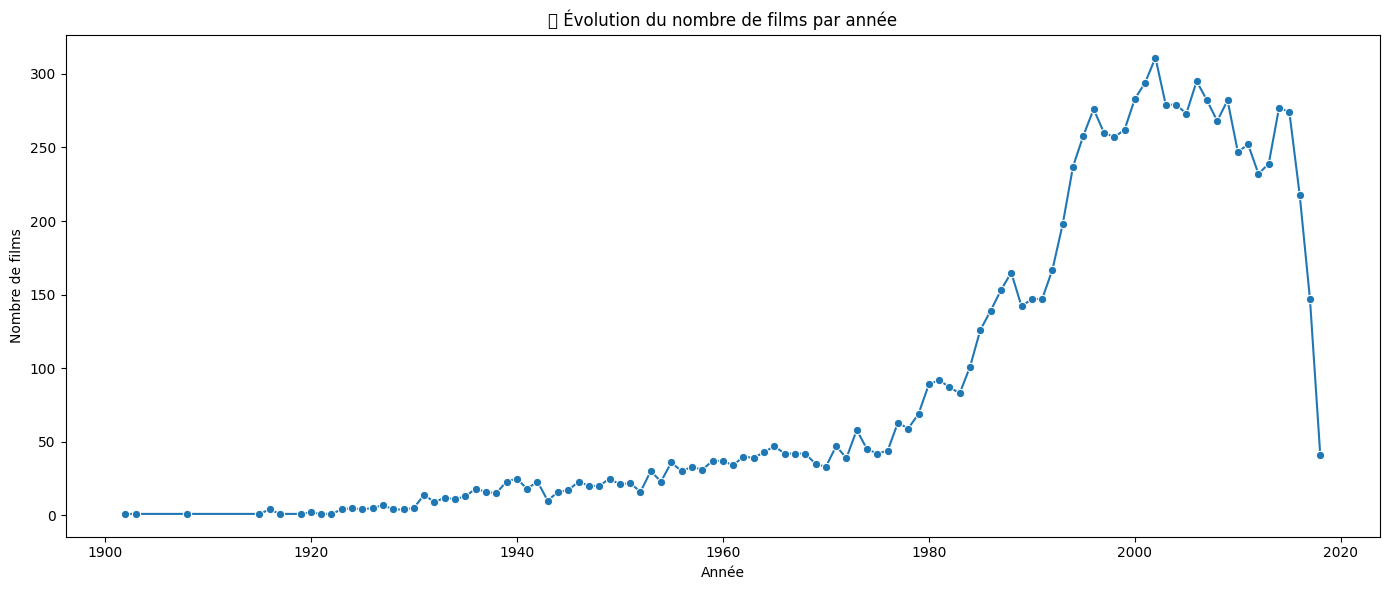

In [65]:
display(Markdown("### 🎬 Nombre de films sortis par année"))

movies_by_year = pd.read_parquet("output/movies_by_year.parquet")

plt.figure(figsize=(14, 6))
sns.lineplot(data=movies_by_year, x="year", y="movie_count", marker="o")
plt.title("📈 Évolution du nombre de films par année")
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()


## 🏆 Top 10 des films les mieux notés

### 🏆 Top 10 des films les mieux notés

C:\Users\kkade\AppData\Local\Temp\ipykernel_17840\2681699880.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




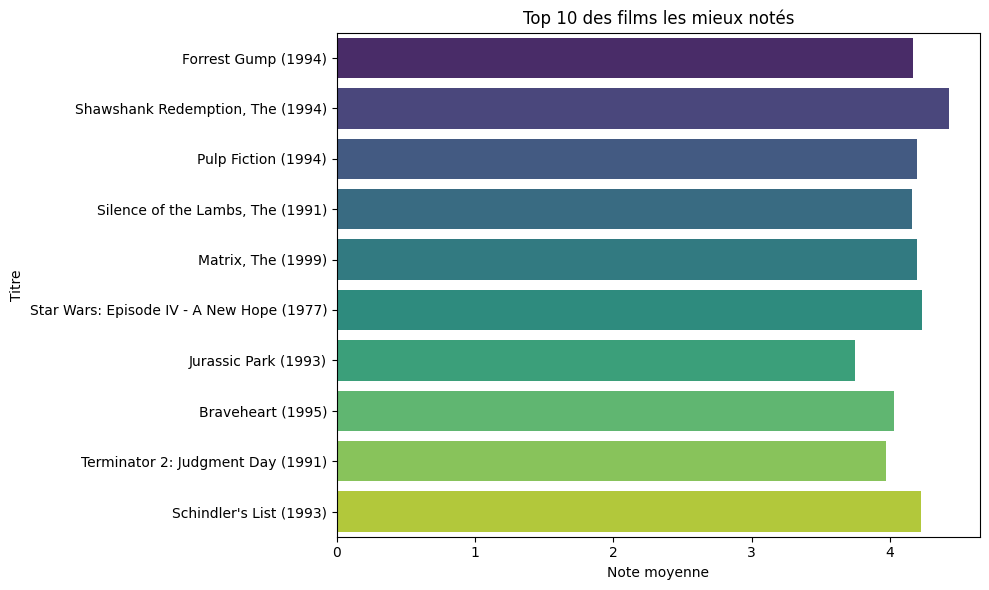

In [66]:
display(Markdown("### 🏆 Top 10 des films les mieux notés"))

top_movies = pd.read_parquet("output/top_movies_by_ratings.parquet")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_movies.head(10),
    x="avg_rating",
    y="title",
    palette="viridis"
)
plt.title("Top 10 des films les mieux notés")
plt.xlabel("Note moyenne")
plt.ylabel("Titre")
plt.tight_layout()
plt.show()


## 📈 Distribution des notes

### 📊 Distribution des notes attribuées

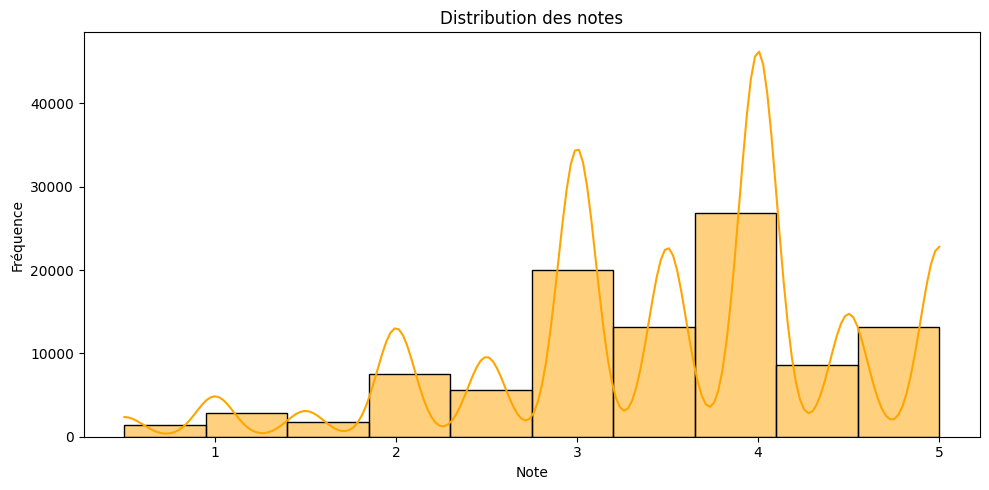

In [67]:
display(Markdown("### 📊 Distribution des notes attribuées"))

plt.figure(figsize=(10, 5))
sns.histplot(ratings_df["rating"], bins=10, kde=True, color="orange")
plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()
